
 <h1 style = "font-size:40px;font-family:verdana;text-align: center;background-color:#DCDCDC">GOOGLE BRAIN:VENTILATOR PRESSURE PREDICTION</h1>
<h2 style = "font-size:30px;font-family:verdana;text-align: center">ORGANIZING HYPERPARAMETER SWEEPS USING W&B</h2>
<center><img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" /></center>

[Reference tutorial from wandb](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb)

[Sweeps docs](https://docs.wandb.ai/guides/sweeps)

<h4 style="font-size:15px;font-family:verdana">Weights & Biases Hyperparameter sweeps provide an organized and efficient way to conduct a battle royale of models and pick the most accurate model. They enable this by automatically searching through combinations of hyperparameter values (e.g. learning rate, batch size, number of hidden layers, optimizer type) to find the most optimal values.</h4>
<h4 style="font-size:15px;font-family:verdana">Running a Hyperparameter sweep with Weights & Biases requires some simple steps that will be illustrated in this notebook.Feel free to fork the notebook and tweak the sweep configuration to suit your requirements</h4>


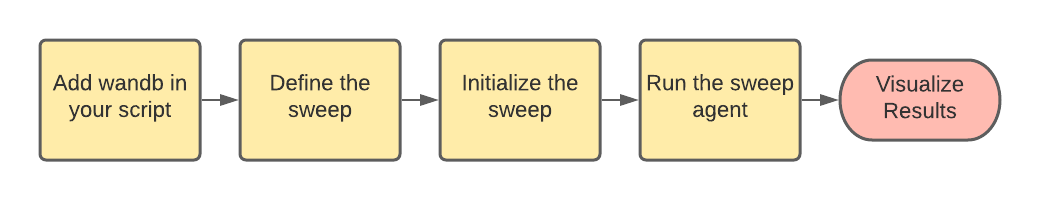

<a href=#sec1>Results Visualization</a><br>


<p style="color:#159364; font-family:cursive;">IMPORT THE REQUIRED LIBRARIES</center></p>


In [ ]:
import os
import gc
import time
import warnings
import numpy as np
import pandas as pd
import math
import torch
import random
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.utils.data import Dataset
warnings.filterwarnings("ignore")
NUM_WORKERS = 4

<p style="color:#159364; font-family:cursive;">CONFIGURATION WITH HYPERPARAMETERS OTHER THAN THOSE IN THE HYPERPARAMETER SEARCH</center></p>

In [ ]:
class Config:
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True
    k = 5
    selected_folds = [0]
    selected_model = 'rnn'
    input_dim = 5
    dense_dim = 512
    logit_dim = 512
    num_classes = 1
    loss = "L1Loss"  
    epochs =150
    warmup_prop = 0
    T_max=50 
    T_0=50 
    min_lr=1e-6
    num_cycles=0.5
    val_bs = 256
    first_epoch_eval = 0

<p style="color:#159364; font-family:cursive;">SEED FUNCTIONS</center></p>


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

<p style="color:#159364; font-family:cursive;">Add W&B in your code</center></p>


In [ ]:
import wandb
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

<p style="color:#159364; font-family:cursive;">LOAD THE DATA</center></p>


In [ ]:
DATA_PATH = "/kaggle/input/ventilator-pressure-prediction/"
sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

<p style="color:#159364; font-family:cursive;">DEFINE THE DATASET CLASS and THE CUSTOM RNN </center></p>

* DATASET CLASS: Note that we are using 5 input features,one is cummulative sum of u_ins feature that is seen to improve the LB score in the competion.Refer to this [discussion](https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/273974 ) for more insights.

* RNN:3 layer MLP,BIDIRECTIONAL LSTM/GRU(type of rnn cell is a hyperparameter) and a Prediction Dense Layer


In [ ]:
# code taken from https://www.kaggle.com/theoviel/deep-learning-starter-simple-lstm

class VentilatorDataset(Dataset):
    def __init__(self, df):
        if "pressure" not in df.columns:
            df['pressure'] = 0

        self.df = df.groupby('breath_id').agg(list).reset_index()
        
        self.prepare_data()
                
    def __len__(self):
        return self.df.shape[0]
    
    def prepare_data(self):
        self.pressures = np.array(self.df['pressure'].values.tolist())
        
        rs = np.array(self.df['R'].values.tolist())
        cs = np.array(self.df['C'].values.tolist())
        u_ins = np.array(self.df['u_in'].values.tolist())
        
        self.u_outs = np.array(self.df['u_out'].values.tolist())
        
        self.inputs = np.concatenate([
            rs[:, None], 
            cs[:, None], 
            u_ins[:, None], 
            np.cumsum(u_ins, 1)[:, None],
            self.u_outs[:, None]
        ], 1).transpose(0, 2, 1)

    def __getitem__(self, idx):
        data = {
            "input": torch.tensor(self.inputs[idx], dtype=torch.float),
            "u_out": torch.tensor(self.u_outs[idx], dtype=torch.float),
            "p": torch.tensor(self.pressures[idx], dtype=torch.float),
        }
        
        return data
    

In [ ]:
class RNNModel(nn.Module):
    def __init__(
        self,
        dropout=0.2,
        rnn_cell='lstm',
        input_dim=5,
        lstm_dim=256, 
        dense_dim=256,
        logit_dim=256,
        num_classes=1,
    ):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, dense_dim // 2),
            nn.ReLU(),
            nn.Linear(dense_dim // 2, dense_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_dim // 2, dense_dim),
            nn.ReLU(),
        )
        self.cell=rnn_cell
        self.lstm = nn.LSTM(dense_dim, lstm_dim, batch_first=True, bidirectional=True)
        self.gru=nn.GRU(dense_dim, lstm_dim, batch_first=True, bidirectional=True)
        self.logits = nn.Sequential(
            nn.Linear(lstm_dim * 2, logit_dim),
            nn.ReLU(),
            nn.Linear(logit_dim, num_classes),
        )

    def forward(self, x):
        features = self.mlp(x)
        if self.cell=='lstm':
            features, _ = self.lstm(features)
        else:
            features, _ = self.gru(features)
        pred = self.logits(features)
        return pred


<h2 style = "font-size:30px;font-family:verdana;text-align: center">Step 1️⃣. Define the Sweep</h2>

<p style="color:#159364; font-family:cursive;">👈 Pick a method</center></p>

*   **grid Search** – Iterate over every combination of hyperparameter values.
Very effective, but can be computationally costly.
*   **random Search** – Select each new combination at random according to provided distributions. Surprisingly effective!
*   **bayesian Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.

I will use random search.

In [ ]:
sweep_config = {
    'method': 'random'
}

<p style="color:#159364; font-family:cursive;">📃 Name the hyperparameters</center></p>

*  This step is straightforward: you just give the parameter a name and specify a list of legal values of the parameter.

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam','sgd','adamw']
        },
    'lstm_dim': {
        'values': [128, 256, 512]
        },
    'dropout':{
        'values': [0.2,0.3,0.4]
    },
    'rnn_cell':{
        'values':['gru','lstm']
    },
    'scheduler':{
        'values':['linear','cosine','CosineAnnealingLR','CosineAnnealingWarmRestarts']
    }
}
sweep_config['parameters'] = parameters_dict

* We also need to specify the metric name ,so that it can be found in the model outputs and also if your goal is to minimize it or maximize it.



In [ ]:
metric = {
    'name': 'MAE',
    'goal': 'minimize'   
    }
sweep_config['metric'] = metric

* For a random search, we can also specify a named distribution,plus its parameters, like the mean mu and standard deviation sigma of a normal distribution.


In [ ]:
parameters_dict.update({
    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.01
      },
    'batch_size': {
        # integers between 128 and 256
        # with evenly-distributed logarithms  
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(128),
        'max': math.log(256),
      }
    })
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")


<h2 style = "font-size:30px;font-family:verdana;text-align: center">Step 2️⃣. Initialize the Sweep</h2>



* The clockwork taskmaster in charge of our Sweep is known as the **Sweep Controller**.As each run completes, it will issue a new set of instructions describing a new run to execute.These instructions are picked up by agents who actually perform the runs.

* In a typical Sweep, the Controller lives on W&B machine,while the agents who complete runs live on our machine(s),like in the diagram below.This division of labor makes it super easy to scale up Sweeps by just adding more machines to run agents!

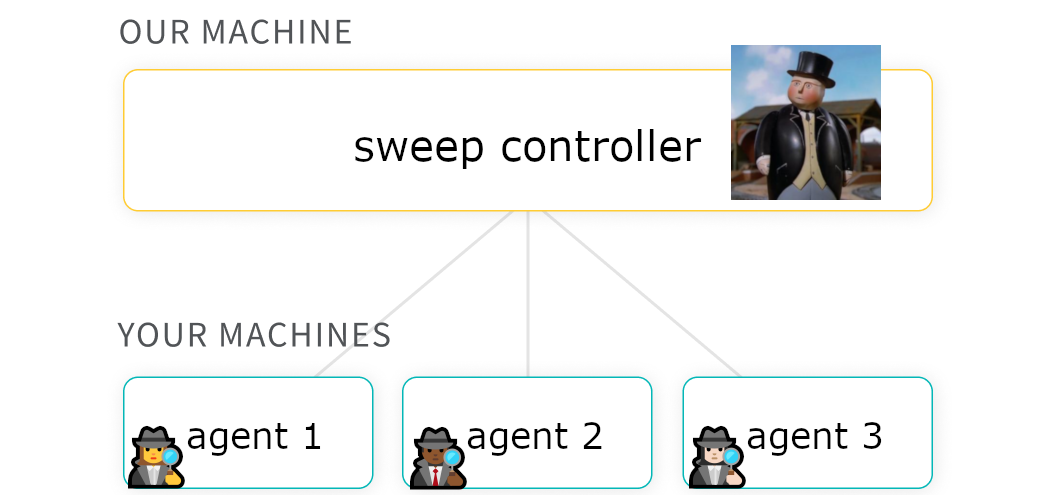

* We can wind up a Sweep Controller by calling wandb.sweep with the appropriate sweep_config and project name.This function returns a sweep_id that we will later user to assign agents to this Controller.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")


<h2 style = "font-size:30px;font-family:verdana;text-align: center">Training</h2>


<p style="color:#159364; font-family:cursive;">Metric & Loss</center></p>



In [ ]:
def compute_metric(df, preds):
    y = np.array(df['pressure'].values.tolist())
    w = 1 - np.array(df['u_out'].values.tolist())
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    return mae

class VentilatorLoss(nn.Module):
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

<p style="color:#159364; font-family:cursive;">FIT</center></p>

* NOTE THE DECLARATION OF **OPTIMIZER** AND **SCHEDULER** AS THEY ARE IN THE HYPERPARAMETER SEARCH

In [ ]:
def fit(
    model,
    CFG,
    train_dataset,
    val_dataset,
    optimizer,
    scheduler,
    batch_size,
    lr,
    verbose,
    first_epoch_eval,
    device,
    loss_name="L1Loss",epochs=50,val_bs=32,
    warmup_prop=0.1
):
    avg_val_loss = 0.

    if optimizer=='sgd':
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=lr, momentum=0.9)
    elif optimizer=='adam':
        optimizer = torch.optim.Adam(model.parameters(),
                              lr=lr)
    elif optimizer=='adamw':
        optimizer = AdamW(model.parameters(),
                              lr=lr)
    

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    loss_fct = VentilatorLoss()
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))

    if scheduler=='linear':
        scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
            )
    elif scheduler=='cosine':
        scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=CFG.num_cycles
            )
    elif scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        
    for epoch in range(epochs):
        model.train()
        model.zero_grad()
        start_time = time.time()

        avg_loss = 0
        for data in train_loader:
            pred = model(data['input'].to(device)).squeeze(-1)

            loss = loss_fct(
                pred,
                data['p'].to(device),
                data['u_out'].to(device),
            ).mean()
            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            optimizer.step()
            scheduler.step()

            for param in model.parameters():
                param.grad = None

        model.eval()
        mae, avg_val_loss = 0, 0
        preds = []

        with torch.no_grad():
            for data in val_loader:
                pred = model(data['input'].to(device)).squeeze(-1)

                loss = loss_fct(
                    pred.detach(), 
                    data['p'].to(device),
                    data['u_out'].to(device),
                ).mean()
                avg_val_loss += loss.item() / len(val_loader)

                preds.append(pred.detach().cpu().numpy())
        
        preds = np.concatenate(preds, 0)
        mae = compute_metric(val_dataset.df, preds)
        wandb.log({"MAE": mae, "epoch": epoch}) 
        
        elapsed_time = time.time() - start_time
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            lr = scheduler.get_last_lr()[0]
            print(
                f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t t={elapsed_time:.0f}s \t"
                f"loss={avg_loss:.3f}",
                end="\t",
            )

            if (epoch + 1 >= first_epoch_eval) or (epoch + 1 == epochs):
                print(f"val_loss={avg_val_loss:.3f}\tmae={mae:.3f}")
            else:
                print("")

    del (val_loader, train_loader, loss, data, pred)
    gc.collect()
    torch.cuda.empty_cache()



<p style="color:#159364; font-family:cursive;">CROSS VALIDATION:GROUP K FOLD</center></p>

* Refer [THIS](https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274137) discussion for better insights on cross validation and type of split.

In [ ]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=Config.k)
splits = list(gkf.split(X=df_train, y=df_train , groups=df_train["breath_id"]))

In [ ]:
df=df_train
for i, (train_idx, val_idx) in enumerate(splits):
        if i in Config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {Config.k}  -------------\n")

            df_train = df.iloc[train_idx].copy().reset_index(drop=True)
            df_val = df.iloc[val_idx].copy().reset_index(drop=True)


<h2 style = "font-size:30px;font-family:verdana;text-align: center">Step 3️⃣. Run the Sweep agent</h2>

* Before we can actually execute the sweep, we need to define the training procedure that uses those values.

<p style="color:#159364; font-family:cursive;">TRAIN</center></p>
In the train function below,we add the following wandb tools to log model metrics,visualize performance and track our experiments.

* **wandb.init()**– Initializes a new W&B Run. Each Run is a single execution of the training function.

* **wandb.config** – Saves all our hyperparameters in a configuration object so they can be logged.

* **wandb.log()** – logs model behavior to W&B. Here, we just log the performance

In [ ]:
def train(con=None,conf=Config, df_train=df_train, df_val=df_val):
    with wandb.init(config=con):
        con=wandb.config
        
        seed_everything(conf.seed)
        
        model = RNNModel(
        dropout=con.dropout,
        rnn_cell=con.rnn_cell,
        input_dim=conf.input_dim,
        lstm_dim=con.lstm_dim,
        dense_dim=conf.dense_dim,
        logit_dim=conf.logit_dim,
        num_classes=conf.num_classes).to(conf.device)
        
        model.zero_grad()

        train_dataset = VentilatorDataset(df_train)
        val_dataset = VentilatorDataset(df_val)    
        
        fit(
        model,
        conf,
        train_dataset,
        val_dataset,
        optimizer=con.optimizer,
        scheduler=con.scheduler,
        batch_size=con.batch_size,
        lr=con.learning_rate,
        verbose=conf.verbose,
        first_epoch_eval=conf.first_epoch_eval,
        device=conf.device,
        loss_name=conf.loss,
        epochs=conf.epochs,
        val_bs=conf.val_bs,
        warmup_prop=conf.warmup_prop
        )
        
    del (model, train_dataset, val_dataset)
    gc.collect()
    torch.cuda.empty_cache()

    

Sweep Controllers, like the one we made by running **wandb.sweep**,
sit waiting for someone to ask them for a **config** to try out.

That someone is an agent, and they are created with **wandb.agent**.
To get going, the agent just needs to know
1. which Sweep it's a part of (sweep_id)
2. which function it's supposed to run (here, train)
3. (optional) how many configs to ask the Controller for (count)

The cell below will launch an agent that runs train 5 times,usingly the randomly-generated hyperparameter values returned by the Sweep Controller. Execution takes under 5 minutes.

In [ ]:
run=wandb.agent(sweep_id, train, count=6)

<a id='sec1'></a>
<h2 style = "font-size:30px;font-family:verdana;text-align: center"> Visualize Sweep Results</h2>
<p style="color:#159364; font-family:cursive;">🔀 Parallel Coordinates Plot</center></p>
This plot maps hyperparameter values to model metrics. It’s useful for honing in on combinations of hyperparameters that led to the best model performance.



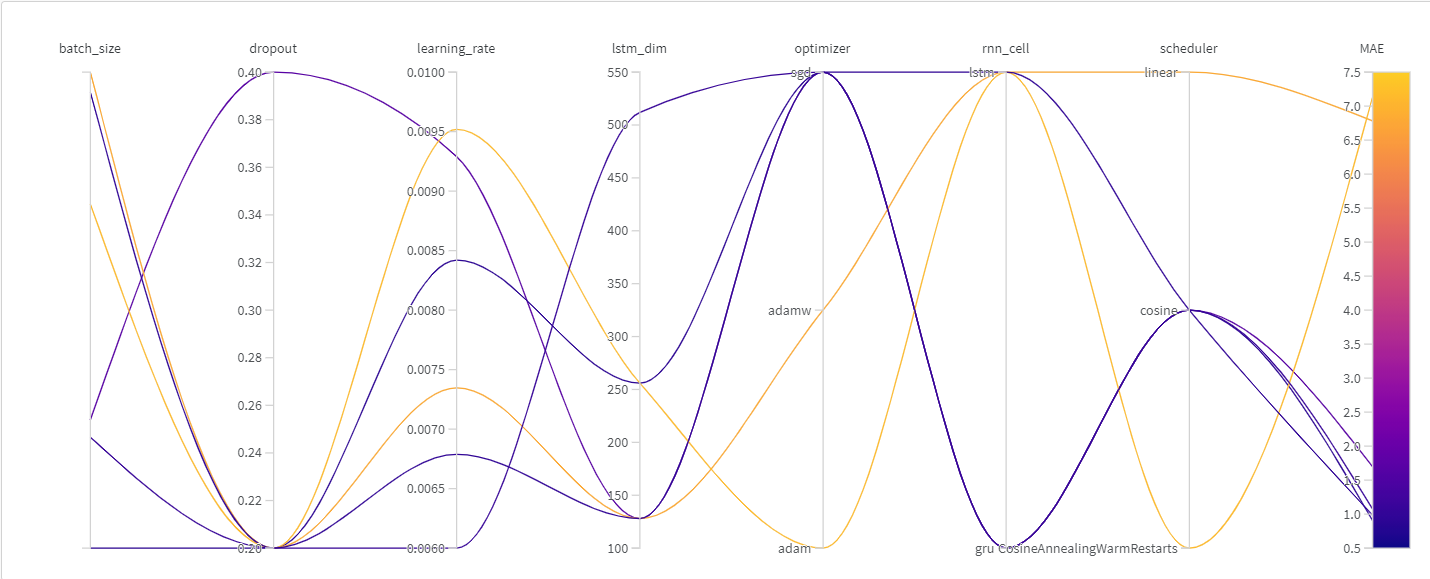

<p style="color:#159364; font-family:cursive;">📊 Hyperparameter Importance Plot</center></p>
The hyperparameter importance plot surfaces which hyperparameters were the best predictors of your metrics. We report feature importance (from a random forest model) and correlation (implicitly a linear model).

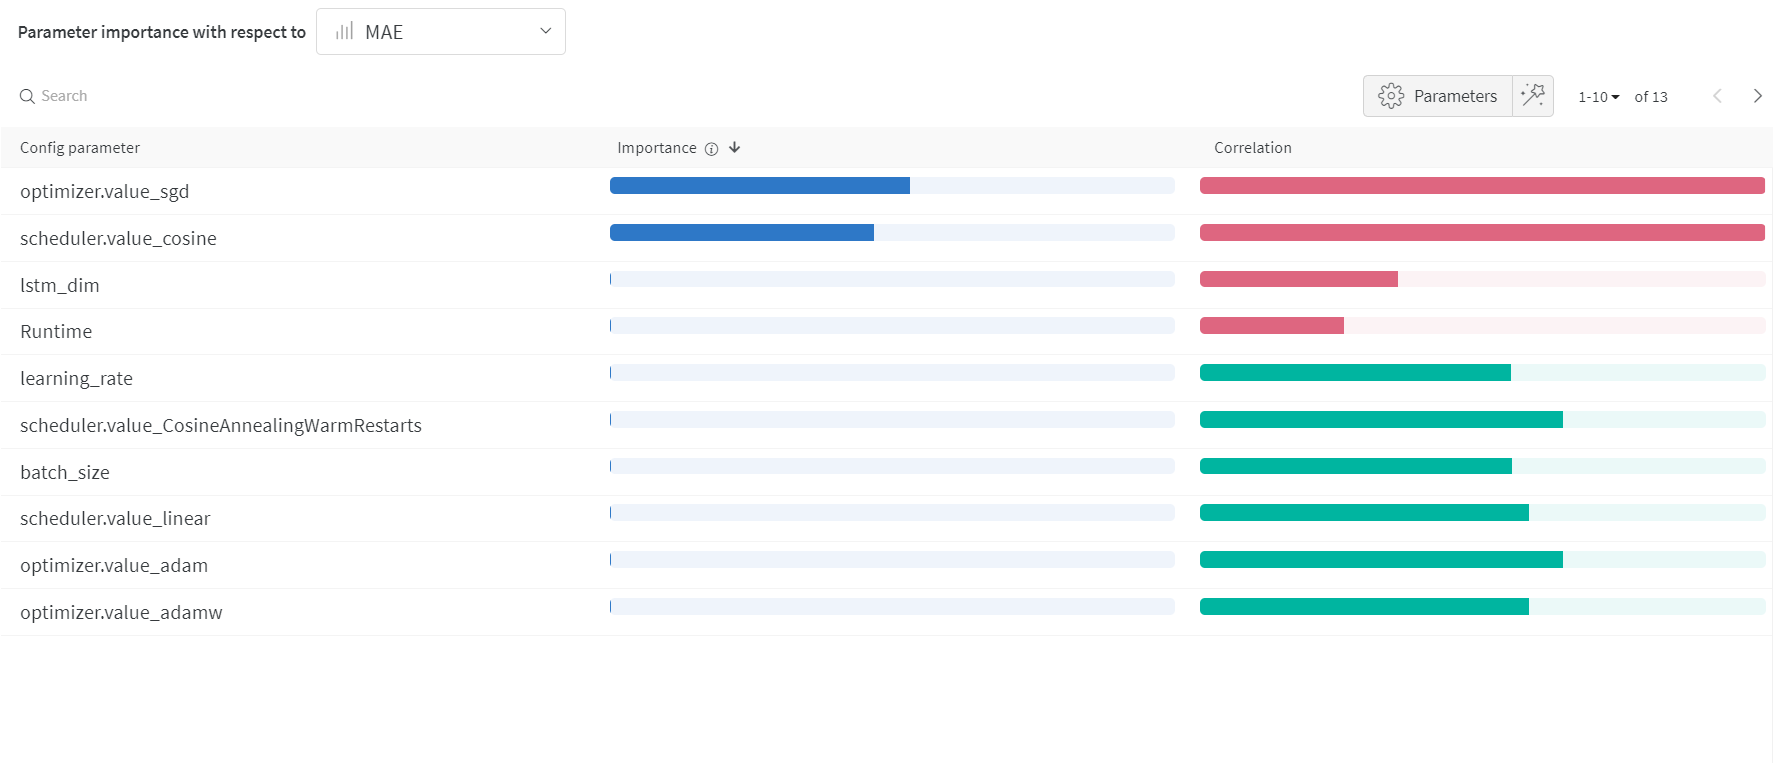

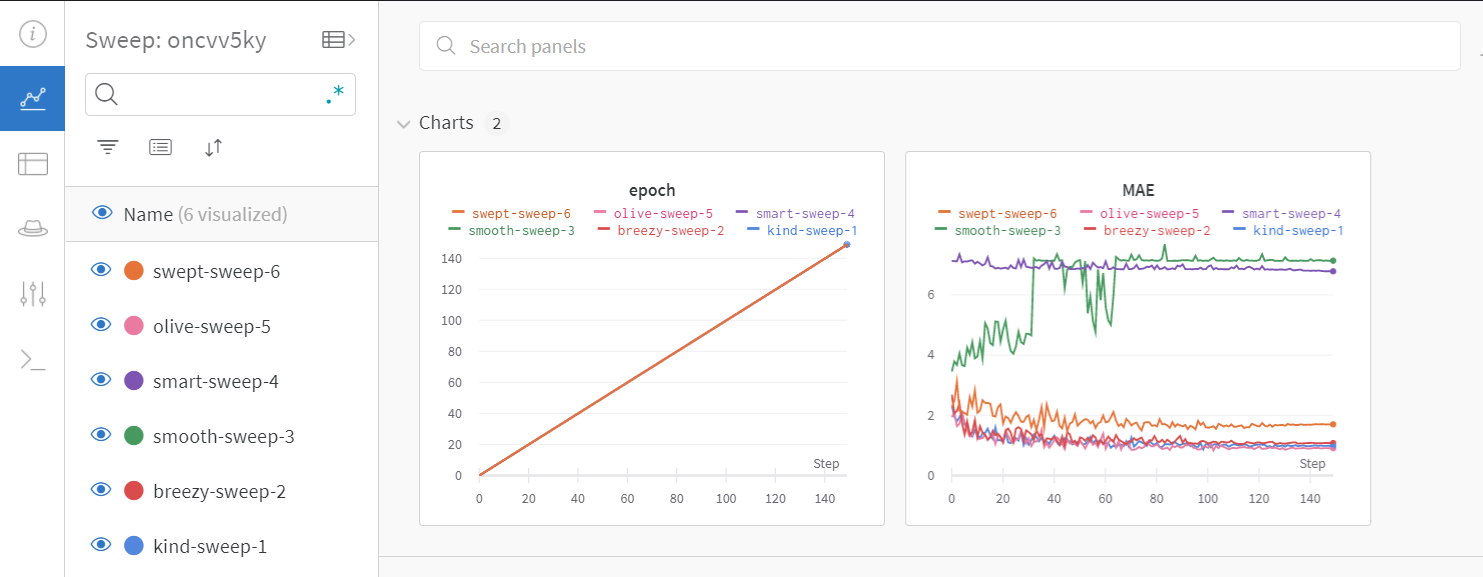

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)